# Importing the Required Libraries

load all necessary libraries here

In [1]:
# common library
import pickle
import pandas as pd 
import time
import string
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
from matplotlib import cm
%matplotlib notebook

#nlp
from gensim.corpora import WikiCorpus
import multiprocessing
from gensim.models.word2vec import LineSentence
from gensim.models import Word2Vec, KeyedVectors
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Dense, LSTM, Bidirectional
from tensorflow.keras.layers import Input,Flatten,Reshape
from tensorflow.keras.layers import GlobalMaxPooling1D, Conv1D, MaxPooling1D
from tensorflow.keras.layers import Embedding,concatenate
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from tensorflow.keras import regularizers
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model

# function
import sys
sys.path.append('function/')
from ursar import nlp

# Load the Wikipedia File

In [3]:
# outp = "wiki.{}.text".format("id")
# i = 0
# print("Starting to create wiki corpus")
# output = open(outp, 'w')
# space = " "
# wiki = WikiCorpus("E:/gitlab/machine-learning/NLP/dataset/idwiki-latest-pages-articles.xml.bz2", lemmatize=False, dictionary={})

# with open("wiki-id-formatted.txt", 'w', encoding="utf8") as output:
#     print("start reading")
#     for text in wiki.get_texts():
#         output.write(' '.join(text)+"\n")

Starting to create wiki corpus
start reading


E:\programs\python\lib\site-packages\gensim\utils.py:1254: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


# Create Word 2 Vector

In [4]:
# import multiprocessing
# from gensim.models import Word2Vec
# from gensim.models.word2vec import LineSentence

# inp = "wiki-id-formatted.txt"
# out_model = "wiki.id.word2vec.model"
# size = 100
# window = 5
# min_count = 5

# start = time.time()

# model = Word2Vec(LineSentence(inp), sg = 0, # 0=CBOW , 1= SkipGram
#        size=size, window=window, min_count=min_count, workers=multiprocessing.cpu_count())

# # trim unneeded model memory = use (much) less RAM
# model.init_sims(replace=True)

# print(time.time()-start)

# model.save(out_model)

502.39766120910645


# save the model

In [6]:
# model.wv.save_word2vec_format('model/wiki.id.word2vec.model', binary=True)

# Load w2v from wikipedia corpus

In [2]:
word_vectors = KeyedVectors.load_word2vec_format('model/wiki.id.word2vec.model', binary=True)

# Importing the Dataset

In [3]:
# load train dataset file here
with open('DATA/clean_text_train', 'rb') as picklefile:
    train = pickle.load(picklefile)

# load test dataset file here
with open('DATA/clean_text_test', 'rb') as picklefile:
    test = pickle.load(picklefile)

In [4]:
# load label train dataset file here
with open('DATA/label_train', 'rb') as picklefile:
    y_train = pickle.load(picklefile)

# load label test dataset file here
with open('DATA/label_test', 'rb') as picklefile:
    y_test = pickle.load(picklefile)

# Preparing the Embedding Layer

In [5]:
vocab_size = 1500
EMBEDDING_DIM=100
max_length = 120
padding_type = 'post'
trunc_type = 'post'

## Tokenizer

use the tokenizer class from the module to create a word-to-index dictionary. In the word-to-index dictionary, each word in the corpus is used as a key, while a corresponding unique index is used as the value for the key

In [6]:
# create the tokenizer
tokenizer = Tokenizer(num_words=vocab_size)
# fit the tokenizer on the documents
tokenizer.fit_on_texts(train)

# encode training data set
X_train = tokenizer.texts_to_sequences(train)
X_train = pad_sequences(X_train, padding=padding_type, maxlen=max_length)
word_index = tokenizer.word_index
print(X_train.shape)

(1780, 120)


In [7]:
X_test = tokenizer.texts_to_sequences(test)
X_test = pad_sequences( X_test, padding=padding_type, maxlen=max_length)
print(X_test.shape)

(185, 120)


# Embedding

In [8]:
vocabulary_size=min(len(word_index)+1,vocab_size)
embedding_matrix = np.zeros((vocabulary_size, EMBEDDING_DIM))
for word, i in word_index.items():
    if i>=vocab_size:
        continue
    try:
        embedding_vector = word_vectors[word]
        embedding_matrix[i] = embedding_vector
    except KeyError:
        embedding_matrix[i]=np.random.normal(0,np.sqrt(0.25),EMBEDDING_DIM)

# Text Classification with CNN

In [9]:
cnn_filters=50
kernel_size = 3
filter_sizes = [3,4,5]
num_filters = 128
drop = 0.5

In [10]:
model = Sequential()

model.add(Embedding(vocabulary_size, EMBEDDING_DIM, weights=[embedding_matrix],
                    input_length=max_length,trainable=True))
# model.add(Dropout(0.5))
model.add(Conv1D(num_filters, kernel_size, padding='same', activation='relu', strides=1,kernel_regularizer=regularizers.l2(0.01)))
model.add(GlobalMaxPooling1D())
model.add(Dense(1,activation='sigmoid'))

model.compile(optimizer="adam", 
              loss='binary_crossentropy', 
              metrics=['acc'])

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 120, 100)          150000    
_________________________________________________________________
conv1d (Conv1D)              (None, 120, 128)          38528     
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 188,657
Trainable params: 188,657
Non-trainable params: 0
_________________________________________________________________
None


# Plot Architecture

<IPython.core.display.Javascript object>


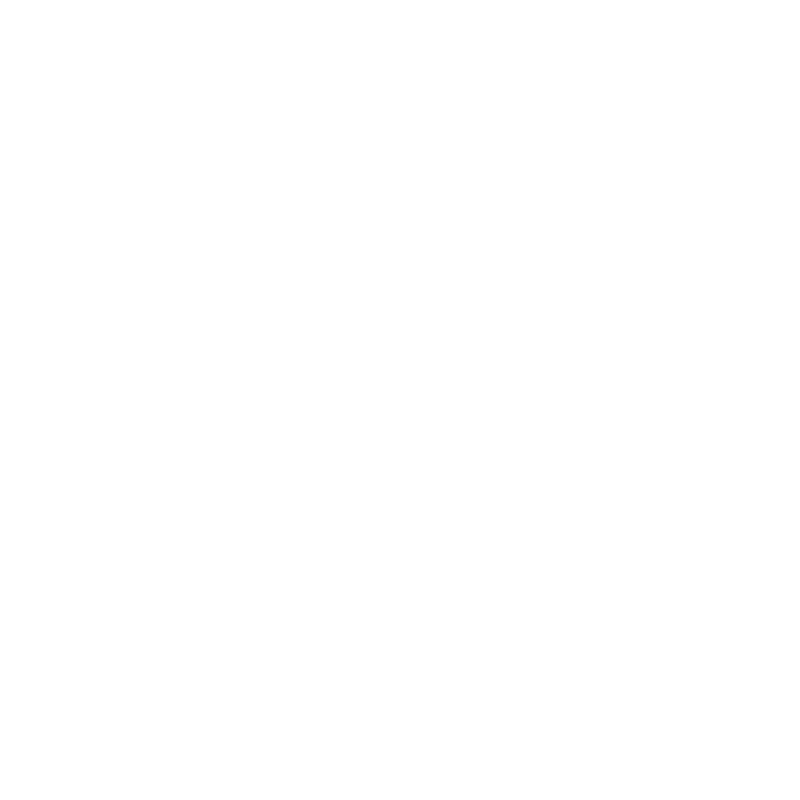

In [11]:
plt.figure(figsize=(8, 8))
plot_model(model, 
           to_file='image/model_CNN_wiki.png', 
           show_shapes=True,
           show_layer_names=True)
plt.show()

# Training

In [12]:
history = model.fit(X_train, y_train, 
                    batch_size=128, 
                    epochs=50, 
                    verbose=1,
                    callbacks = [
                        ReduceLROnPlateau(),
                        EarlyStopping(patience=4),
                        ModelCheckpoint(filepath='model/model_CNN_wiki.h5', 
                                        save_best_only=True)],
                    validation_split=0.2)

Epoch 1/50
12/12 [==============================] - 1s 89ms/step - loss: 1.6849 - acc: 0.5716 - val_loss: 1.4942 - val_acc: 0.6517 - lr: 0.0010
Epoch 2/50
12/12 [==============================] - 0s 20ms/step - loss: 1.3437 - acc: 0.6819 - val_loss: 1.2451 - val_acc: 0.6545 - lr: 0.0010
Epoch 3/50
12/12 [==============================] - 0s 21ms/step - loss: 1.1041 - acc: 0.6910 - val_loss: 1.0465 - val_acc: 0.6545 - lr: 0.0010
Epoch 4/50
12/12 [==============================] - 0s 19ms/step - loss: 0.9295 - acc: 0.6966 - val_loss: 0.9090 - val_acc: 0.6573 - lr: 0.0010
Epoch 5/50
12/12 [==============================] - 0s 22ms/step - loss: 0.8006 - acc: 0.7184 - val_loss: 0.8061 - val_acc: 0.6657 - lr: 0.0010
Epoch 6/50
12/12 [==============================] - 0s 20ms/step - loss: 0.7055 - acc: 0.7367 - val_loss: 0.7328 - val_acc: 0.6713 - lr: 0.0010
Epoch 7/50
12/12 [==============================] - 0s 21ms/step - loss: 0.6337 - acc: 0.7837 - val_loss: 0.6754 - val_acc: 0.7022 - lr:

## Evaluation

In [13]:
cnn_model = load_model('model/model_CNN_wiki.h5')
loss, accuracy = cnn_model.evaluate(X_train, y_train, verbose=False)
print("\nTraining Accuracy: {:.4f}".format(accuracy))
print("Training loss:  {:.4f}".format(loss))
loss, accuracy = cnn_model.evaluate(X_test, y_test, verbose=False)
print("\nTesting Accuracy:  {:.4f}".format(accuracy))
print("Testing loss:  {:.4f}".format(loss))


Training Accuracy: 0.9393
Training loss:  0.2860

Testing Accuracy:  0.7730
Testing loss:  0.5976


# plot history

<IPython.core.display.Javascript object>


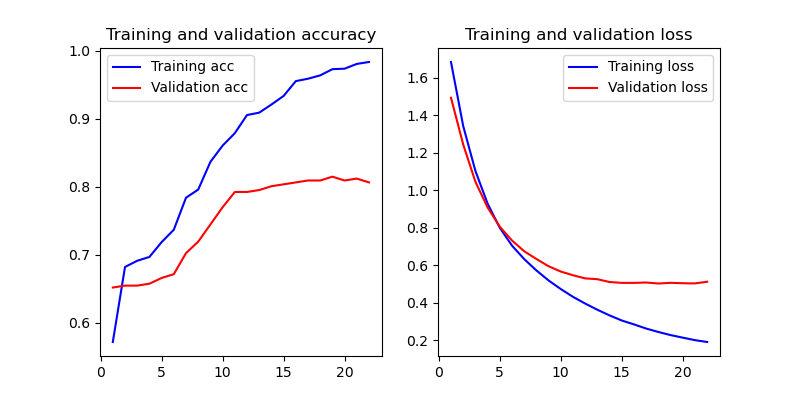

In [14]:
# this function has been save in function/ursar.py so we can call it for every model we create
nlp.plot_history(history)

# Text Classification with CNN-LSTM

In [15]:
inputs = Input(shape=(max_length,))
embedding_layer = Embedding(vocabulary_size,
                        EMBEDDING_DIM,
                        weights=[embedding_matrix],
                        trainable=True)
embedding = embedding_layer(inputs)

conv_0 = Conv1D(num_filters, filter_sizes[0],activation='relu',kernel_regularizer=regularizers.l2(0.01))(embedding)
conv_1 = Conv1D(num_filters, filter_sizes[1],activation='relu',kernel_regularizer=regularizers.l2(0.01))(embedding)
conv_2 = Conv1D(num_filters, filter_sizes[2],activation='relu',kernel_regularizer=regularizers.l2(0.01))(embedding)

maxpool_0 = MaxPooling1D(max_length - filter_sizes[0] + 1, strides=1)(conv_0)
maxpool_1 = MaxPooling1D(max_length - filter_sizes[1] + 1, strides=1)(conv_1)
maxpool_2 = MaxPooling1D(max_length - filter_sizes[2] + 1, strides=1)(conv_2)

merged_tensor = concatenate([maxpool_0, maxpool_1, maxpool_2], axis=1)
flatten = Flatten()(merged_tensor)

dense1 = Dense(256)(merged_tensor)
dropout = Dropout(drop)(dense1)
lstm_1 = LSTM(128)(dropout)
output = Dense(units=1, activation='sigmoid',kernel_regularizer=regularizers.l2(0.01))(lstm_1)

# this creates a model that includes
model = Model(inputs, output)

model.compile(optimizer="adam", 
              loss='binary_crossentropy', 
              metrics=['acc'])

print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 120)]        0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 120, 100)     150000      input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 118, 128)     38528       embedding_1[0][0]                
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 117, 128)     51328       embedding_1[0][0]                
______________________________________________________________________________________________

# Plot Architecture

<IPython.core.display.Javascript object>


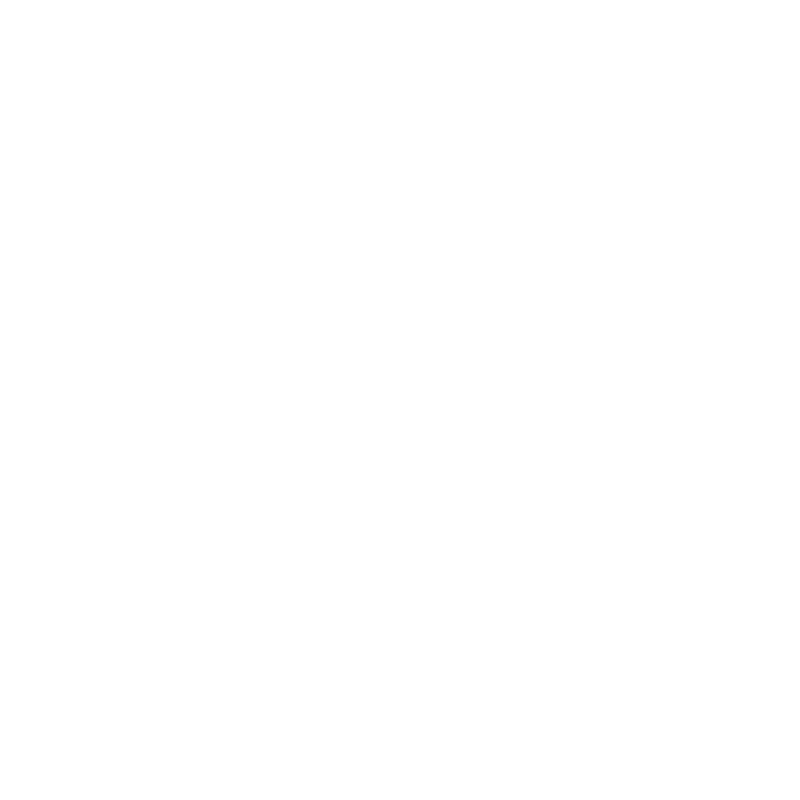

In [17]:
plt.figure(figsize=(8, 8))
plot_model(model, 
           to_file='image/model_CNN_LSTM_wiki.png', 
           show_shapes=True,
           show_layer_names=True)
plt.show()

In [18]:
history = model.fit(X_train, y_train, 
                    batch_size=32, 
                    epochs=100, 
                    verbose=1,
                    callbacks = [
                        ReduceLROnPlateau(),
                        EarlyStopping(patience=4),
                        ModelCheckpoint(filepath='model/model_CNN_LSTM_wiki.h5', 
                                        save_best_only=True)],
                    validation_split=0.1)

Epoch 1/100
51/51 [==============================] - 3s 54ms/step - loss: 2.1298 - acc: 0.6710 - val_loss: 1.0472 - val_acc: 0.6292 - lr: 0.0010
Epoch 2/100
51/51 [==============================] - 1s 25ms/step - loss: 0.7358 - acc: 0.7097 - val_loss: 0.5992 - val_acc: 0.8258 - lr: 0.0010
Epoch 3/100
51/51 [==============================] - 1s 24ms/step - loss: 0.4792 - acc: 0.8533 - val_loss: 0.5763 - val_acc: 0.8202 - lr: 0.0010
Epoch 4/100
51/51 [==============================] - 1s 18ms/step - loss: 0.3168 - acc: 0.9326 - val_loss: 0.5994 - val_acc: 0.7809 - lr: 0.0010
Epoch 5/100
51/51 [==============================] - 1s 17ms/step - loss: 0.2709 - acc: 0.9557 - val_loss: 0.6524 - val_acc: 0.7978 - lr: 0.0010
Epoch 6/100
51/51 [==============================] - 1s 17ms/step - loss: 0.2869 - acc: 0.9563 - val_loss: 0.8191 - val_acc: 0.8315 - lr: 0.0010
Epoch 7/100
51/51 [==============================] - 1s 17ms/step - loss: 0.1743 - acc: 0.9888 - val_loss: 0.7623 - val_acc: 0.814

## Evaluation

In [19]:
cnn_lstm_model = load_model('model/model_CNN_LSTM_wiki.h5')
loss, accuracy = cnn_lstm_model.evaluate(X_train, y_train, verbose=False)
print("\nTraining Accuracy: {:.4f}".format(accuracy))
print("Training loss:  {:.4f}".format(loss))
loss, accuracy = cnn_lstm_model.evaluate(X_test, y_test, verbose=False)
print("\nTesting Accuracy:  {:.4f}".format(accuracy))
print("Testing loss:  {:.4f}".format(loss))


Training Accuracy: 0.9298
Training loss:  0.3320

Testing Accuracy:  0.7676
Testing loss:  0.6052


# plot history

<IPython.core.display.Javascript object>


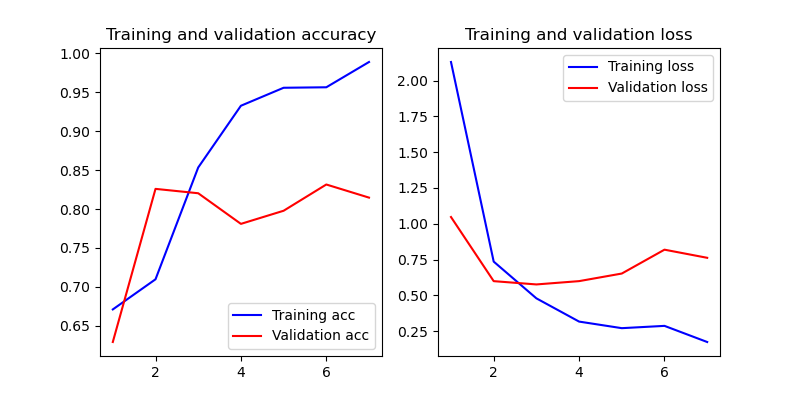

In [25]:
# this function has been save in function/ursar.py so we can call it for every model we create
nlp.plot_history(history)

# Making a Prediction for New Reviews

In [21]:
# classify a review as negative (0) or positive (1)
def predict_sentiment(review, model):
    # apply preprocess_text function to out training dataset
    reviews = []
    print(review)
    reviews.append(nlp.preprocess_text(review))
    # encode
    encoded = nlp.tokenize_embedding(reviews,'post', 120)
    # prediction
    yhat = model.predict(encoded, verbose=0)
    if (yhat[0,0]>=0.5):
        res = "positive review"
    else:
        res = "negative review"
    return (res,yhat[0,0])

In [22]:
# load model
cnn_lstm_model = load_model('model/model_CNN_LSTM_wiki.h5')

In [23]:
# test positive text
text = 'Saya telah mencoba pasta dan pizza yang mereka hidangkan, rasanya…. Enak!'
print(predict_sentiment(text, cnn_lstm_model))

Saya telah mencoba pasta dan pizza yang mereka hidangkan, rasanya…. Enak!
('positive review', 0.9526966)
